# 신용대출 심사 변수중요도

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 여러분에게 모델링을 의뢰하였습니다.
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있는 것에 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다.

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
-----------------


* 고객에게 제공한 예측 모델
    * 여러분은 다양한 알고리즘과 튜닝을 통해 모델을 생성하였습니다.
    * 모델의 정확도가 상당히 높다고 평가 되었습니다.
    * 고객은 여러분의 결과물에 대해 기뻐하고 있습니다. 그리고 한가지 질문을 해 왔습니다.
        * **"이번에 제공한 예측 모델의 정확도가 높아 상당히 만족스럽습니다. 그런데 궁금한 점이 있습니다. 모델이 신용도를 예측하는데 중요한 요인은 무엇인가요?"**

* 본 과제를 통해서 다음을 수행합니다.
    * 다양한 알고리즘으로 모델을 만들고 성능 평가하기
    * 트리 모델로 부터 변수 중요도 확인하기
    * 그 외 모델(SVM, DL 등) 변수 중요도 확인하기

# 라이브러리 불러오기

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

# 필요한 함수 정의하기

In [4]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수중요도, feature 이름 정리
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 데이터프레임으로 변환
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    # 중요도 순으로 정렬
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 전체? or top N?
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 정리한 변수 중요도 df return
    return fi_df

# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

# 데이터 로드하기

In [6]:
path = './data/credit.csv'
data = pd.read_csv(path)
data

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1,12,2,3,1680,5,4,1,1,35,2,1,3,1,1,1
996,1,1,42,2,2,7882,4,3,4,2,45,3,1,3,2,1,1
997,0,2,54,0,9,15945,2,3,4,4,58,1,1,3,1,2,1
998,1,2,15,3,3,1537,5,3,4,1,50,2,2,3,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|  
|	-----	|	-----	|	-----	|	-----	|  
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|  
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|  
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|  
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |  
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|  
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|  
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|  
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|  
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|  
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|  
|	Age	|	Age (years)	|	나이	|		|  
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|  
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|  
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|  
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|  
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|  


In [7]:
data.shape

(1000, 17)

- Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


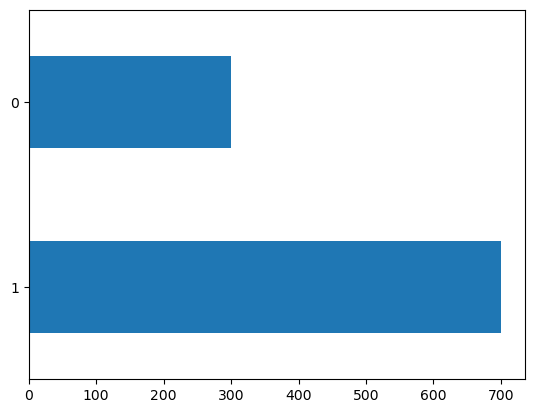

In [9]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts(normalize = True))

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

# 데이터 준비하기

#### 1) x, y로 나누기

In [10]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

#### 2) 가변수화

In [11]:
dummy_vars = ['SexMarital', 'MostValuableAsset','ForeignWorker','Telephone']

x = pd.get_dummies(x, columns = dummy_vars, drop_first = True)
x.head()

,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4,ForeignWorker_2,Telephone_2
0,3,24,2,0,1249,2,2,28,2,1,3,1,0,0,1,0,0,0,0,0
1,2,9,2,0,276,3,4,22,1,1,2,1,0,0,1,0,0,0,0,0
2,1,18,3,2,1049,2,4,21,1,1,3,1,1,0,0,1,0,0,0,0
3,1,24,3,1,6419,5,4,44,3,2,4,2,1,0,0,0,0,1,0,1
4,3,12,2,2,1424,5,4,55,2,1,4,1,1,0,0,0,0,0,0,1


#### 3) train : validation 분할

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)

# 모델링 및 변수 중요도 확인하기
* 모델 생성
    * decision tree, random forest, xgb 알고리즘을 이용하여 각각 모델을 만드시오.
    * 모델을 튜닝하시오.
* 성능 및 변수 중요도 비교
    * 성능이 가장 좋은 모델을 선정하시오.
    * 성능이 가장 좋은 모델의 변수 중요도와 그렇지 않은 모델의 변수 중요도를 비교하시오.

In [15]:
models = list()

## 1. decision tree

In [13]:
# DecisionTree 모델 생성
dt_model = DecisionTreeClassifier()


# Grid Search를 위한 params설정 및 모델 생성
params = {'max_depth':range(1,20)}

gs_dt_model = GridSearchCV(dt_model, params, cv=20)

gs_dt_model.fit(x_train, y_train)

GridSearchCV(cv=20, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 20)})

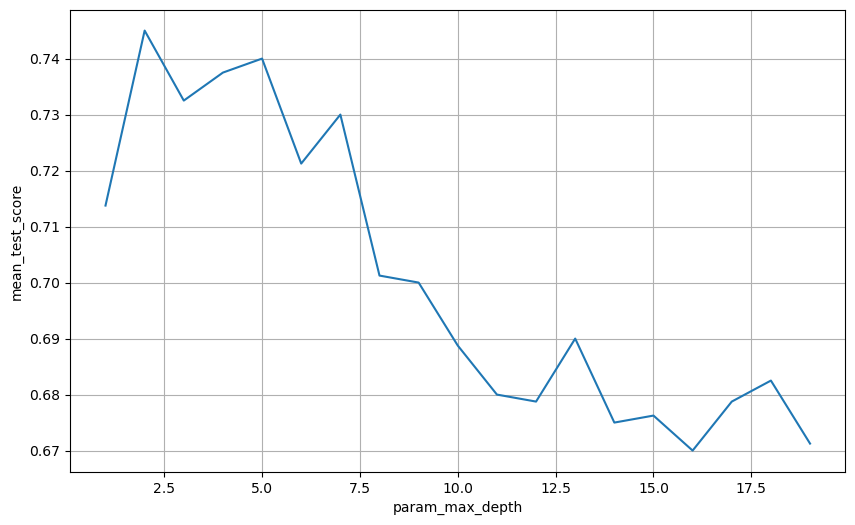

In [79]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(gs_dt_model.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

##### 최적화 된 모델 설정하기

In [16]:
DT_best_model = gs_dt_model.best_estimator_

models.append(DT_best_model)

DT_best_model

DecisionTreeClassifier(max_depth=2)

## 2. random forest

In [21]:
# Random Forest 모델 생성
rf_model = RandomForestClassifier()

# Grid Search를 위한 params설정 및 모델 생성
params = {
    'max_depth' : range(1,10),
    'max_features' : range(1,5),
    'n_estimators' : range(1,5)}

gs_rf_model = GridSearchCV(rf_model, params, cv=5)

gs_rf_model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 10), 'max_features': range(1, 5),
                         'n_estimators': range(1, 5)})

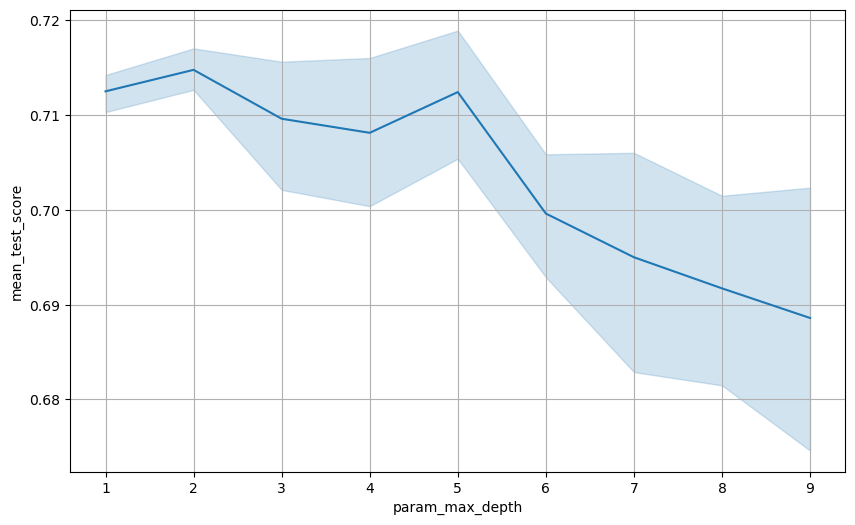

In [81]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(gs_rf_model.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

##### 최적화 된 모델 설정하기

In [22]:
RF_best_model = gs_rf_model.best_estimator_

models.append(RF_best_model)

RF_best_model

RandomForestClassifier(max_depth=5, max_features=3, n_estimators=3)

## 3. xgboost

In [23]:
# XGBoost 모델 생성
xgb_model = XGBClassifier()

# Grid Search를 위한 params설정 및 모델 생성
params = {'max_depth':range(1,8,2), 
          'learning_rate':[0.01, 0.05, 0.1, 0.2], 
          'n_estimators':range(50,151,20)}

GS_XGB_model = GridSearchCV(xgb_model, params, cv=5)
GS_XGB_model.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': range(1, 8, 2),
                         'n_estimators': range(50, 151, 20)})

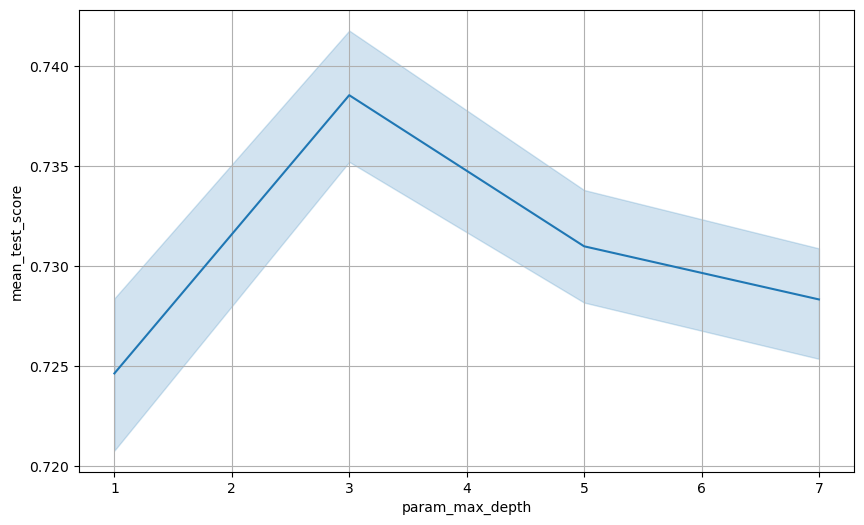

In [80]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(GS_XGB_model.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

##### 최적화 된 모델 설정하기

In [24]:
XGB_best_model = GS_XGB_model.best_estimator_

models.append(XGB_best_model)

XGB_best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=70, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 4. 모델 성능 비교

In [25]:
models

[DecisionTreeClassifier(max_depth=2),
 RandomForestClassifier(max_depth=5, max_features=3, n_estimators=3),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.2, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=70, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)]

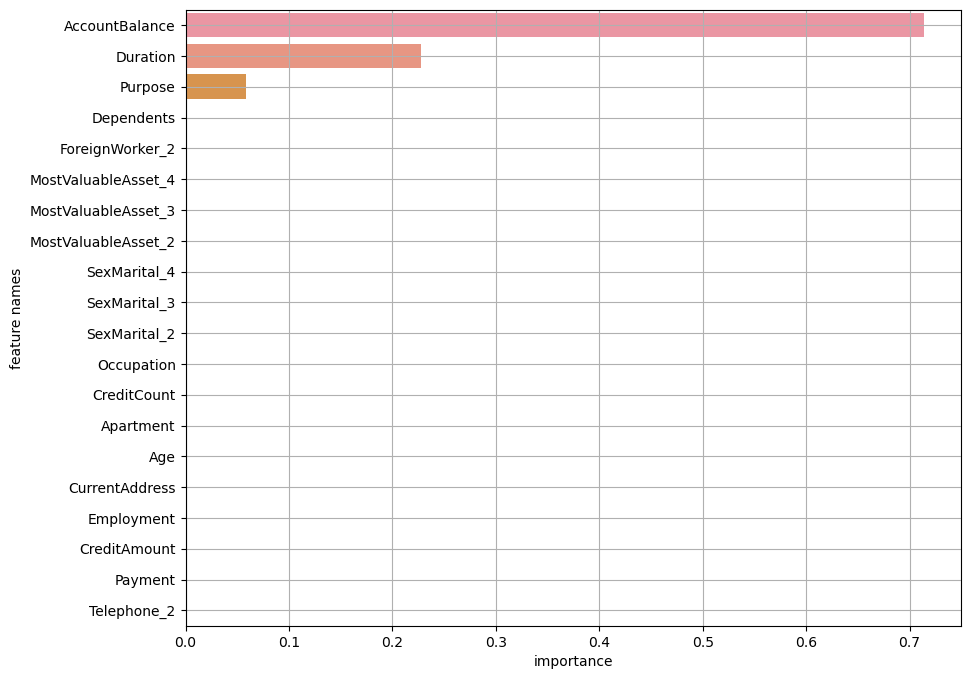

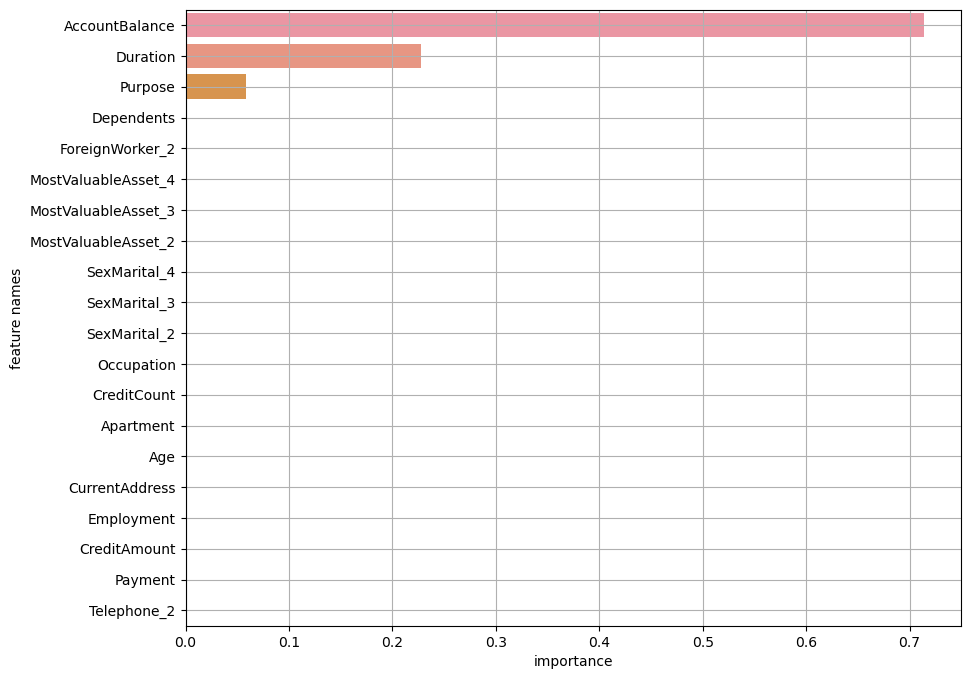

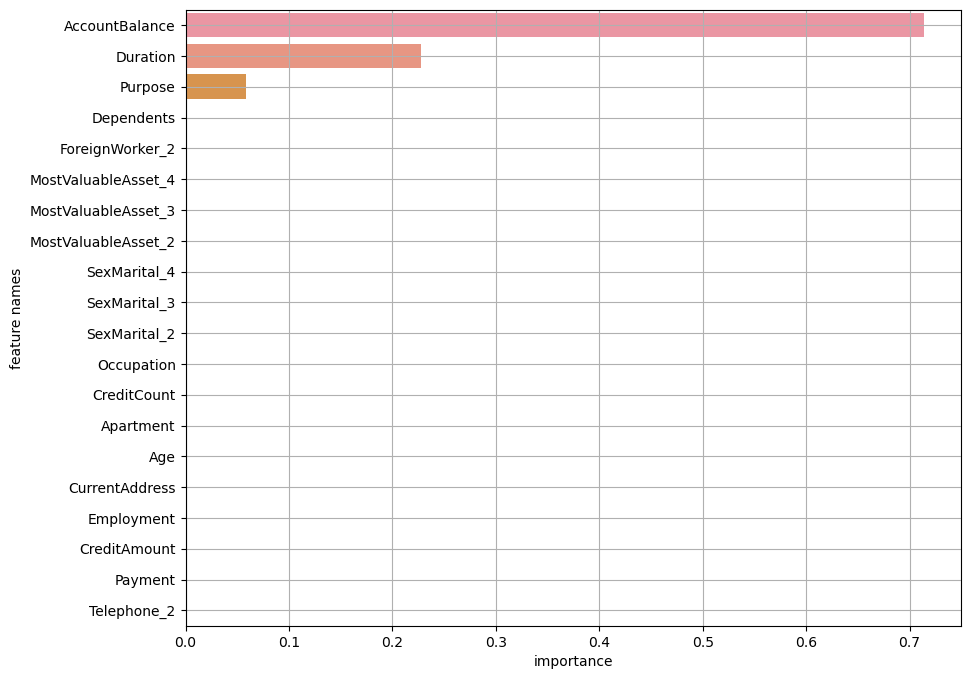

In [28]:
results = []
for model in models:
    results.append(plot_feature_importance(DT_best_model.feature_importances_, list(x_train))) 

## 5. 모델 평가하기

- decision tree

In [76]:
dt_pred = DT_best_model.predict(x_val)
print(classification_report(y_val, dt_pred))

              precision    recall  f1-score   support

           0       0.56      0.39      0.46        71
           1       0.71      0.83      0.77       129

    accuracy                           0.68       200
   macro avg       0.64      0.61      0.61       200
weighted avg       0.66      0.68      0.66       200



- Random Forest

In [77]:
rf_pred = RF_best_model.predict(x_val)
print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.75      0.13      0.22        71
           1       0.67      0.98      0.79       129

    accuracy                           0.68       200
   macro avg       0.71      0.55      0.51       200
weighted avg       0.70      0.68      0.59       200



- XGB

In [78]:
xgb_pred = XGB_best_model.predict(x_val)
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.76      0.48      0.59        71
           1       0.76      0.91      0.83       129

    accuracy                           0.76       200
   macro avg       0.76      0.70      0.71       200
weighted avg       0.76      0.76      0.74       200



# Permutation Feature Importance
* 변수 중요도를 제공하지 않는 모델 생성
    * SVM, KNN, DL 혹은 그외 알고리즘으로 모델을 생성하시오.
    * 알고 있는 방법을 최대한 동원하여 모델을 각각 최적화 하시오.
* 성능 및 변수 중요도 비교
    * 트리 모델과 성능 비교
    * Permutation Feature Importance 를 이용하여 변수 중요도를 뽑아 봅시다.


In [29]:
from sklearn.inspection import permutation_importance

* 스케일링

In [30]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

# 모델링

In [56]:
models_for_pfi=[]

## 1. SVM 모델

In [57]:
svm_model = SVC()
svm_model.fit(x_train_s, y_train)

models_for_pfi.append(svm_model)

svm_model

SVC()

## 2. KNN 모델

In [58]:
knn_model = KNeighborsClassifier()

knn_model.fit(x_train_s, y_train)

models_for_pfi.append(knn_model)

knn_model

KNeighborsClassifier()

## 3. Deep Learning 모델

In [59]:
x_train_s.shape[1]

20

In [40]:
nfeatures = x_train_s.shape[1]
clear_session()

dl_model = Sequential([Dense(32, input_shape = [nfeatures,], activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(1, activation = 'sigmoid')
                     ])

dl_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
history = model2.fit(x_train_s, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
20/20 [==============================] - 0s 12ms/step - loss: 0.3195 - accuracy: 0.8703 - val_loss: 0.5813 - val_accuracy: 0.7250
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3176 - accuracy: 0.8734 - val_loss: 0.5850 - val_accuracy: 0.7688
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3169 - accuracy: 0.8719 - val_loss: 0.5891 - val_accuracy: 0.7563
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.3179 - accuracy: 0.8797 - val_loss: 0.5831 - val_accuracy: 0.7437
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.3138 - accuracy: 0.8750 - val_loss: 0.5878 - val_accuracy: 0.7625
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.3124 - accuracy: 0.8734 - val_loss: 0.5876 - val_accuracy: 0.7250
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.3137 - accuracy: 0.8719 - val_loss: 0.5931 - val_accuracy: 0.7688
Epoch 8/100


Epoch 59/100
20/20 [==============================] - 0s 7ms/step - loss: 0.2476 - accuracy: 0.9172 - val_loss: 0.6791 - val_accuracy: 0.7063
Epoch 60/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2477 - accuracy: 0.9156 - val_loss: 0.6815 - val_accuracy: 0.7188
Epoch 61/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2474 - accuracy: 0.9156 - val_loss: 0.6814 - val_accuracy: 0.7063
Epoch 62/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2481 - accuracy: 0.9156 - val_loss: 0.6828 - val_accuracy: 0.7125
Epoch 63/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2546 - accuracy: 0.9062 - val_loss: 0.6909 - val_accuracy: 0.6750
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2469 - accuracy: 0.9078 - val_loss: 0.6847 - val_accuracy: 0.7250
Epoch 65/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2437 - accuracy: 0.9156 - val_loss: 0.6873 - val_accuracy: 0.7375
Epoch 

In [60]:
models_for_pfi.append(dl_model)

dl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 945 (3.69 KB)
Trainable params: 945 (3.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 4. 모델 성능 비교

In [61]:
models_for_pfi

[SVC(),
 KNeighborsClassifier(),

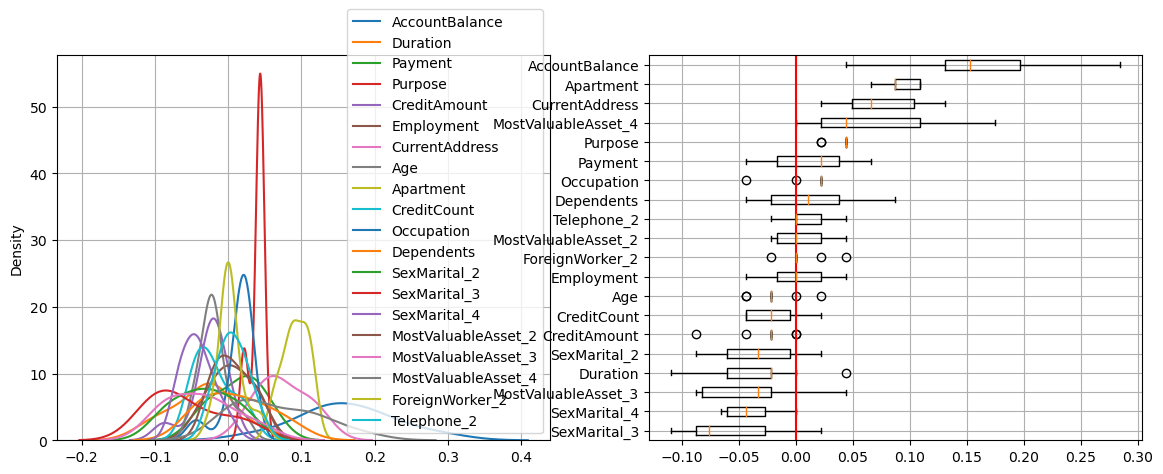

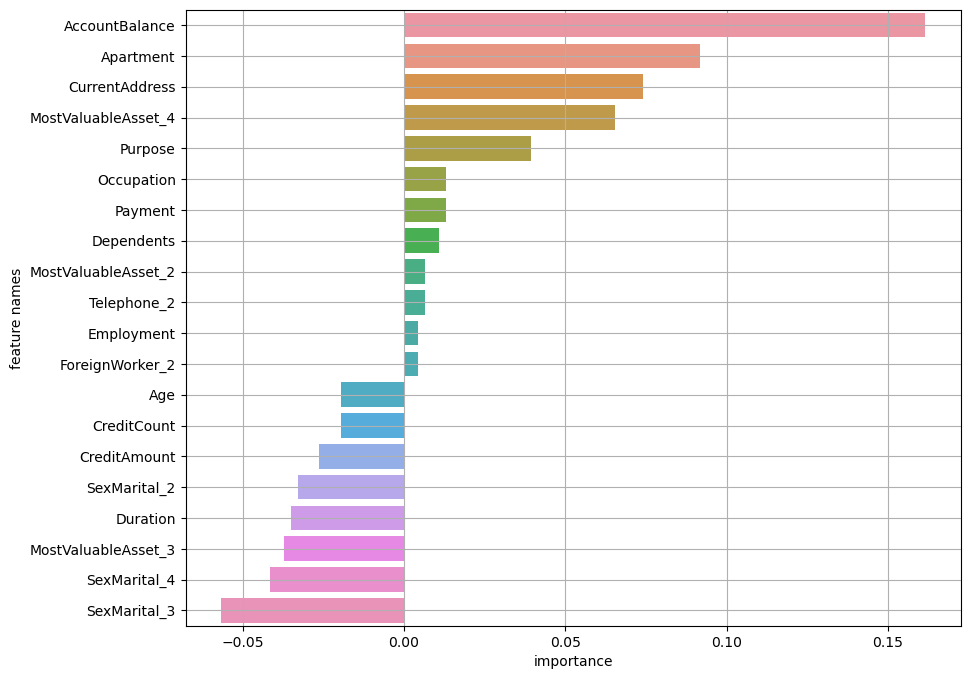

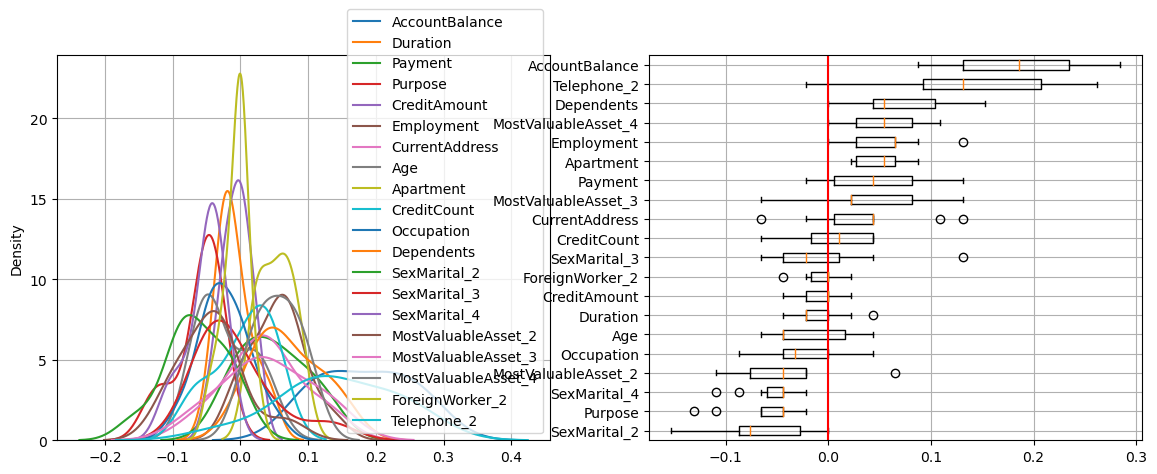

7/7 [==============================] - 0s 3ms/step


7/7 [==============================] - 0s 3ms/step


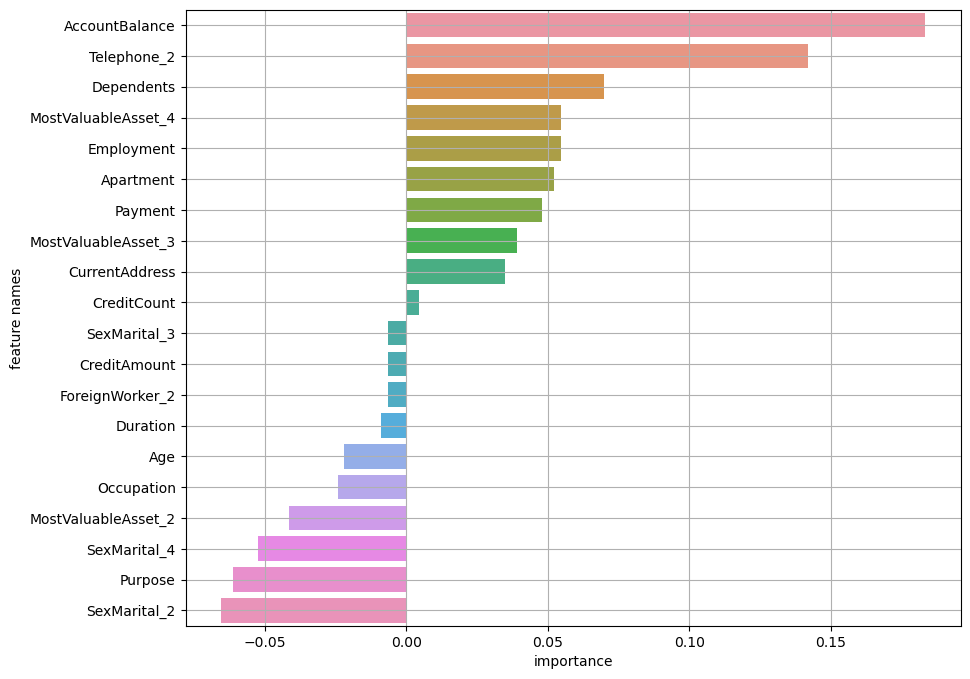

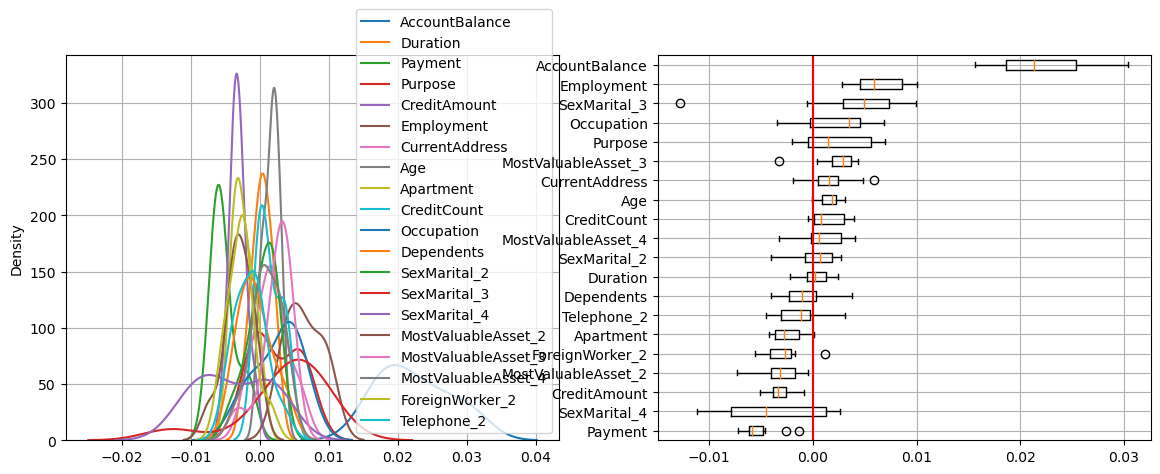

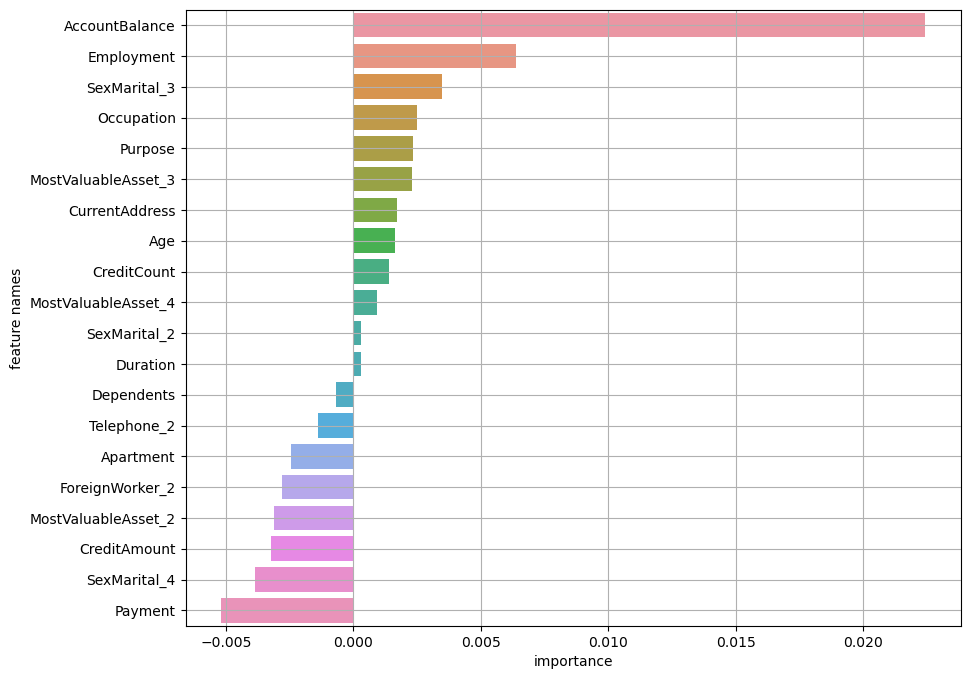

In [65]:
pfi_results = []
for model in models_for_pfi:
    pfi = permutation_importance(model, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=2023)
    
    plot_PFI(pfi, x.columns)
    pfi_results.append(plot_feature_importance(pfi.importances_mean, list(x_train)))

## 5. 모델 평가하기

- SVM

In [67]:
svm_pred = svm_model.predict(x_val_s)
print(classification_report(y_val, svm_pred))

              precision    recall  f1-score   support

           0       0.66      0.27      0.38        71
           1       0.70      0.92      0.79       129

    accuracy                           0.69       200
   macro avg       0.68      0.60      0.59       200
weighted avg       0.68      0.69      0.65       200



- KNN

In [68]:
knn_pred = knn_model.predict(x_val_s)
print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.62      0.25      0.36        71
           1       0.69      0.91      0.79       129

    accuracy                           0.68       200
   macro avg       0.66      0.58      0.57       200
weighted avg       0.67      0.68      0.64       200



- Deep Learning

In [75]:
dl_pred = knn_model.predict(x_val_s).flatten()
dl_pred = np.where(dl_pred > 0.5, 2 , 1) #0.5보다크면 2, 작으면 1

print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.62      0.25      0.36        71
           1       0.69      0.91      0.79       129

    accuracy                           0.68       200
   macro avg       0.66      0.58      0.57       200
weighted avg       0.67      0.68      0.64       200

